## Preliminaries for data processing and analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.cross_validation import cross_val_score,LeaveOneOut,ShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import scale
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier

import scratch as s

Using Theano backend.


## Load, fill, and check the larger data set that Joe sent me.  

In [2]:
guide = pandas.read_excel('bbdp/data/D20Mar2015a.xls') # Load the excel file containing the dictionary.  
dementia_labels = [row[0] for _,row in guide.iterrows() \
                   if row[2].__class__.__name__ == 'str' and 'Yes with Dementia' in row[2]] # Extract dementia status.
df = pandas.read_excel('bbdp/data/D20Mar2015a.xls',sheetname='Data',index_col=0) # Load the data from the Excel file.  

pathological = df.iloc[:,4:25].drop('ipspp',1) # Ignore IPSPP which is tricky.  
pathological = 1*(pathological > 0) # Set pathology status to either 0 or 1 (binarize). 
pathological = pathological.loc[:,pathological.sum()>0] # Include only those conditions with 
                                                        # at least one pathological diagnosis.  

# Add gender and smell features including all the UPSIT question responses.  
clinical = df.loc[:,['female','smell_reduced_or_absent']+['smell_%d' % q for q in range(1,41)]]
clinical['smell_reduced_or_absent'].fillna(0, inplace=True) # Impute NaN with 0 for qualitative smell assessment.  
clinical['dementia'] = [np.any([row[col_label]==2 for col_label in dementia_labels]) \
                         for row_label,row in df.iterrows()] # Set a binary dementia feature.  
clinical['test_age'] = df['deathage'] - df['stint'] # Determine the age at test time.  

# Replace the actual UPSIT responses ('a', 'b', etc.) with indicator variables (1 or 0)
# reflecting whether they selected 'a', 'b', etc.  
for q in range(1,41):
    for i,letter in enumerate(['a','b','c','d']):
        clinical['smell_%d%s' % (q,letter)] = clinical['smell_%d' % q]==(i+1)
    clinical.drop('smell_%d' % q,axis=1,inplace=True)

In [3]:
# Verify that the pathological data is sensible, i.e. that certain combinations of things the must or must not
# go together in fact do or do not go together, respectively.  

p = pathological
#assert p[(p.demunp>0) & (various dementias)].size == 0
assert p[(p.lbdins>0) & ((p.ilbd>0) | (p.dlbp>0) | (p.pddefined>0) | (p.parkismp>0))].size == 0
assert p[(p.ilbd>0) & ((p.ad>0) | (p.vascp>0) | (p.ftdpdefined>0) | \
                       (p.dlbp>0) | (p.pddefined>0) | (p.parkismp>0) | (p.pspp>0) | (p.cbdp>0))].size == 0
assert p[(p.parkismp>0) & ((p.dlbp>0) | (p.lbdins>0) | (p.ilbd>0) | \
                           (p.pddefined>0) | (p.pspp>0) | (p.cbdp>0))].size == 0

In [4]:
# Create a master data frame.  
master = pathological.join(clinical)

## Create matrices

In [5]:
from sklearn.ensemble import RandomForestClassifier
X = clinical.as_matrix().astype(float) # All features should be floats.  
Y = pathological.as_matrix().astype(bool) # All pathologies should be booleans, i.e. 1 or 0.  

In [6]:
# Create several subsets of the feature matrix to determine which features are important.  
X1 = clinical.as_matrix().astype(float) # All the UPSIT data (plus total and gender/age/dementia).  
X2 = X[:,:4] # Only the totals (plus total and gender/age/dementia). 
X3 = clinical[['female','test_age','dementia']].as_matrix().astype(float) # Just gender/age/dementia. 
Xs = {'all':X1, 'total':X2, 'basic':X3} # Dictionary for quick access to these matrices.  

## Do classification using random forests.  

In [7]:
# Compute fraction correct for each of the three matrices (basic, total, and all).
# Note that for rare diagnoses, it is easy to get fraction correct near 1
# just by guessing "no".  
shuffle_split = ShuffleSplit(Y.shape[0],n_iter=25,test_size=0.2,random_state=0)
for i in range(14):
    print(pathological.columns.values[i])
    clf = RandomForestClassifier(n_estimators=100,max_features=None)
    for key in ['basic','total','all']:
        val = s.cross_validate(clf,Xs[key],Y[:,i],shuffle_split,key)

ad
Cross-validation accuracy for basic is 0.541
Cross-validation accuracy for total is 0.544
Cross-validation accuracy for all is 0.608
vascp
Cross-validation accuracy for basic is 0.876
Cross-validation accuracy for total is 0.891
Cross-validation accuracy for all is 0.931
demunp
Cross-validation accuracy for basic is 0.973
Cross-validation accuracy for total is 0.982
Cross-validation accuracy for all is 0.987
ftdpdefined
Cross-validation accuracy for basic is 0.996
Cross-validation accuracy for total is 0.997
Cross-validation accuracy for all is 0.998
tau
Cross-validation accuracy for basic is 0.879
Cross-validation accuracy for total is 0.881
Cross-validation accuracy for all is 0.913
hs
Cross-validation accuracy for basic is 0.996
Cross-validation accuracy for total is 0.998
Cross-validation accuracy for all is 0.998
ag
Cross-validation accuracy for basic is 0.781
Cross-validation accuracy for total is 0.785
Cross-validation accuracy for all is 0.853
dlbp
Cross-validation accuracy 

In [8]:
# Run the classifier and many CV splits and store the results including the diagnosis probabilities on the test set. 
Y_cv,p,p1,p0 = {},{},{},{}
for key,X in Xs.items():
    max_features = 40 if key=='all' else None
    rfc = RandomForestClassifier(n_estimators=50,max_features=max_features)
    Y_cv[key], p[key], p1[key], p0[key] = s.roc_data(X,Y,rfc,n_iter=25,test_size=0.1)

In [9]:
# Create a data frame to store the results.  
ps = s.build_p_frame(p0,p1,pathological,guide)
ps.head()

,Diagnosis,Predicted Probability,Outcome
0,AD,0.32,--
1,AD,0.48,--
2,AD,0.30,--
3,AD,0.42,--
4,AD,0.36,--


## Display results for random forests.  

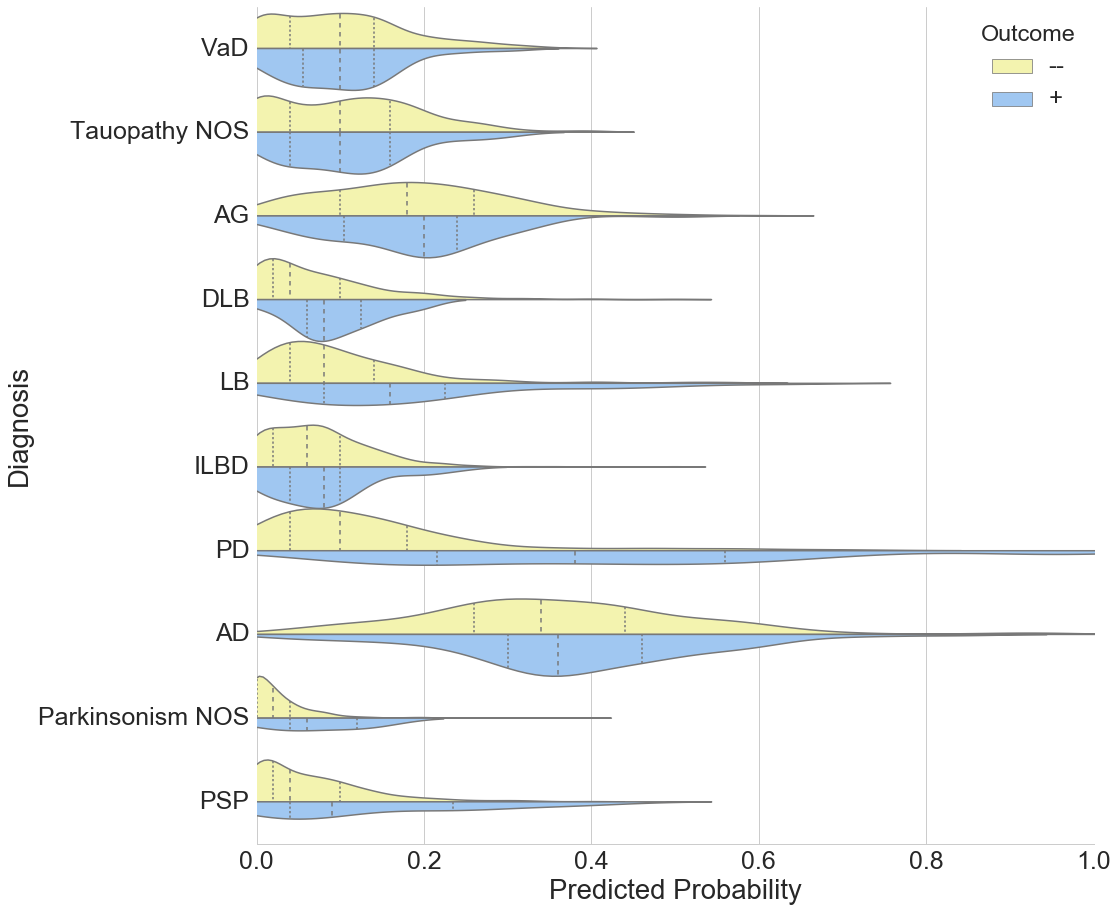

In [10]:
s.violin_roc(ps) # Make a plot showing probability densities of predicted probabilities 
                 # for cases with vs without the label.  

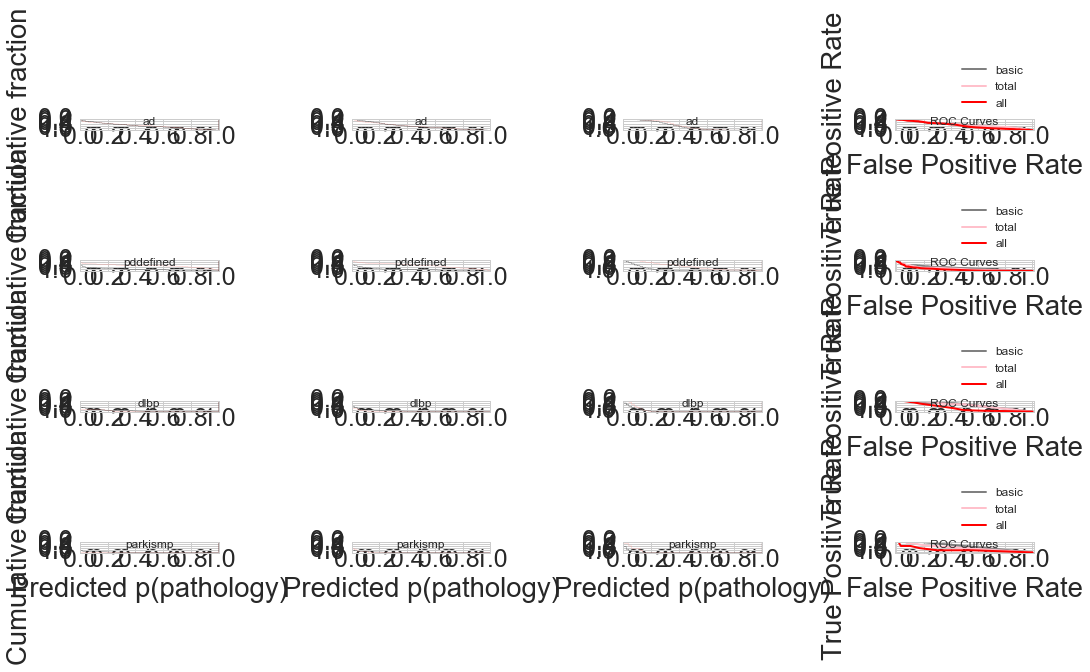

In [11]:
s.plot_roc_curves_with_ps(Y,Y_cv,Xs,p0,p1,p,pathological,diagnoses=['ad','pddefined','dlbp','parkismp'])

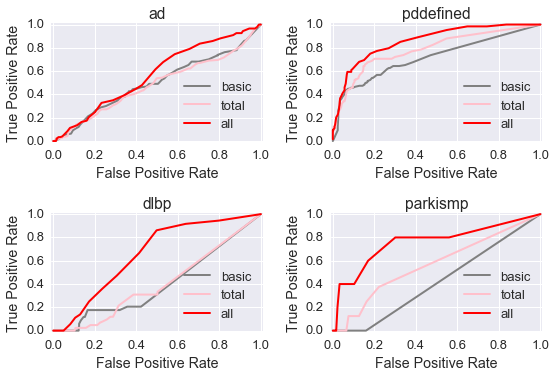

In [12]:
sns.set(font_scale=1.3)
diagnoses = ['ad','pddefined','dlbp','parkismp']
fig,ax = plt.subplots(2,2)
for i,diagnosis in enumerate(diagnoses):
    ix = list(pathological.columns.values).index(diagnosis)
    s.plot_roc_curves({key:Y_cv[key][ix] for key in Y_cv},
                      {key:p[key][ix] for key in p},
                      ax=ax.flat[i],label='sparse',title=diagnosis)
fig.tight_layout()

In [13]:
#from sklearn.calibration import CalibratedClassifierCV

## Do classification using Multinomial Naive Bayes.  

In [14]:
Y_cv,p,p1,p0 = {},{},{},{}
for key,X in Xs.items():
    mnb = MultinomialNB(alpha=0.1,fit_prior=True)
    clf = OneVsRestClassifier(mnb)
    Y_cv[key], p[key], p1[key], p0[key] = s.roc_data(X,Y,clf,n_iter=None,test_size=None)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 13 is present in all training examples.
  str(classes[c]))


In [15]:
ps = s.build_p_frame(p0,p1,pathological,guide)
ps.head()

,Diagnosis,Predicted Probability,Outcome
0,AD,0.032925,--
1,AD,0.007982,--
2,AD,0.006948,--
3,AD,0.999674,--
4,AD,0.000672,--


## Display results for Multinomial Naive Bayes.  

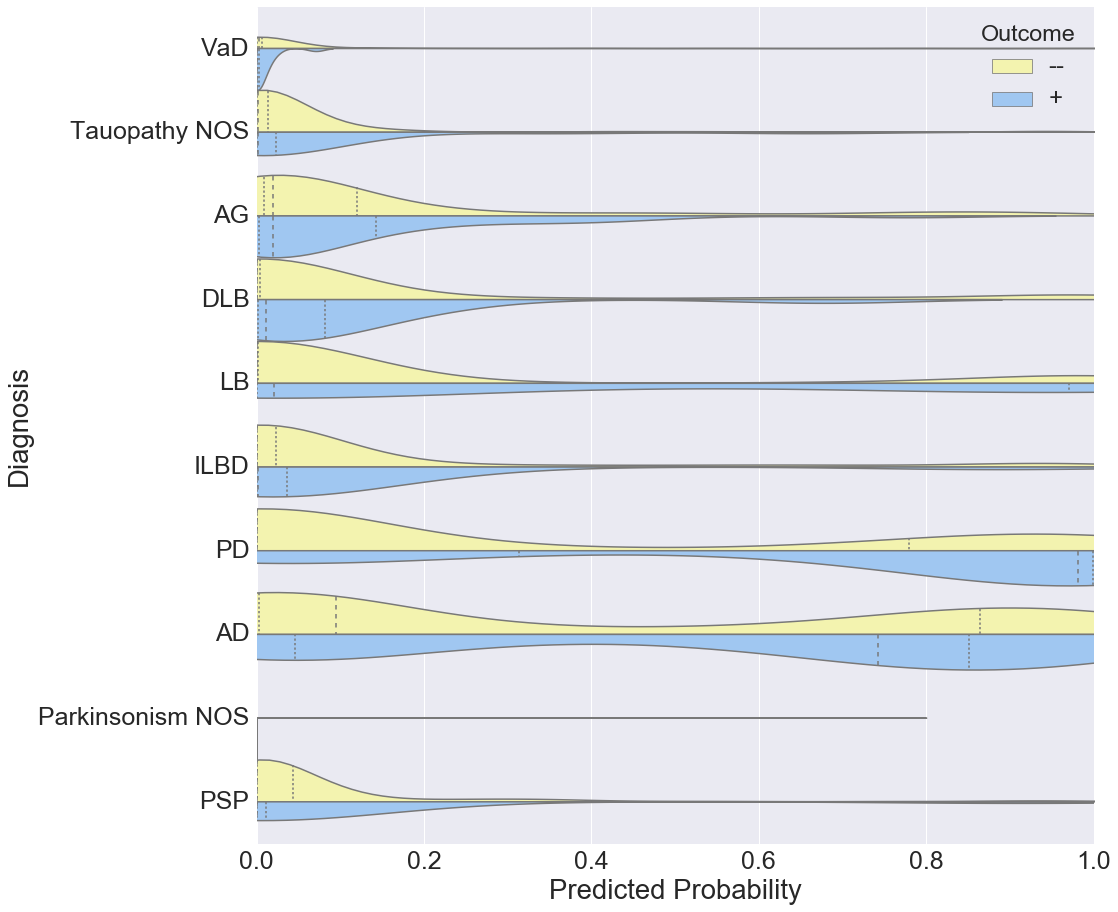

In [16]:
s.violin_roc(ps)

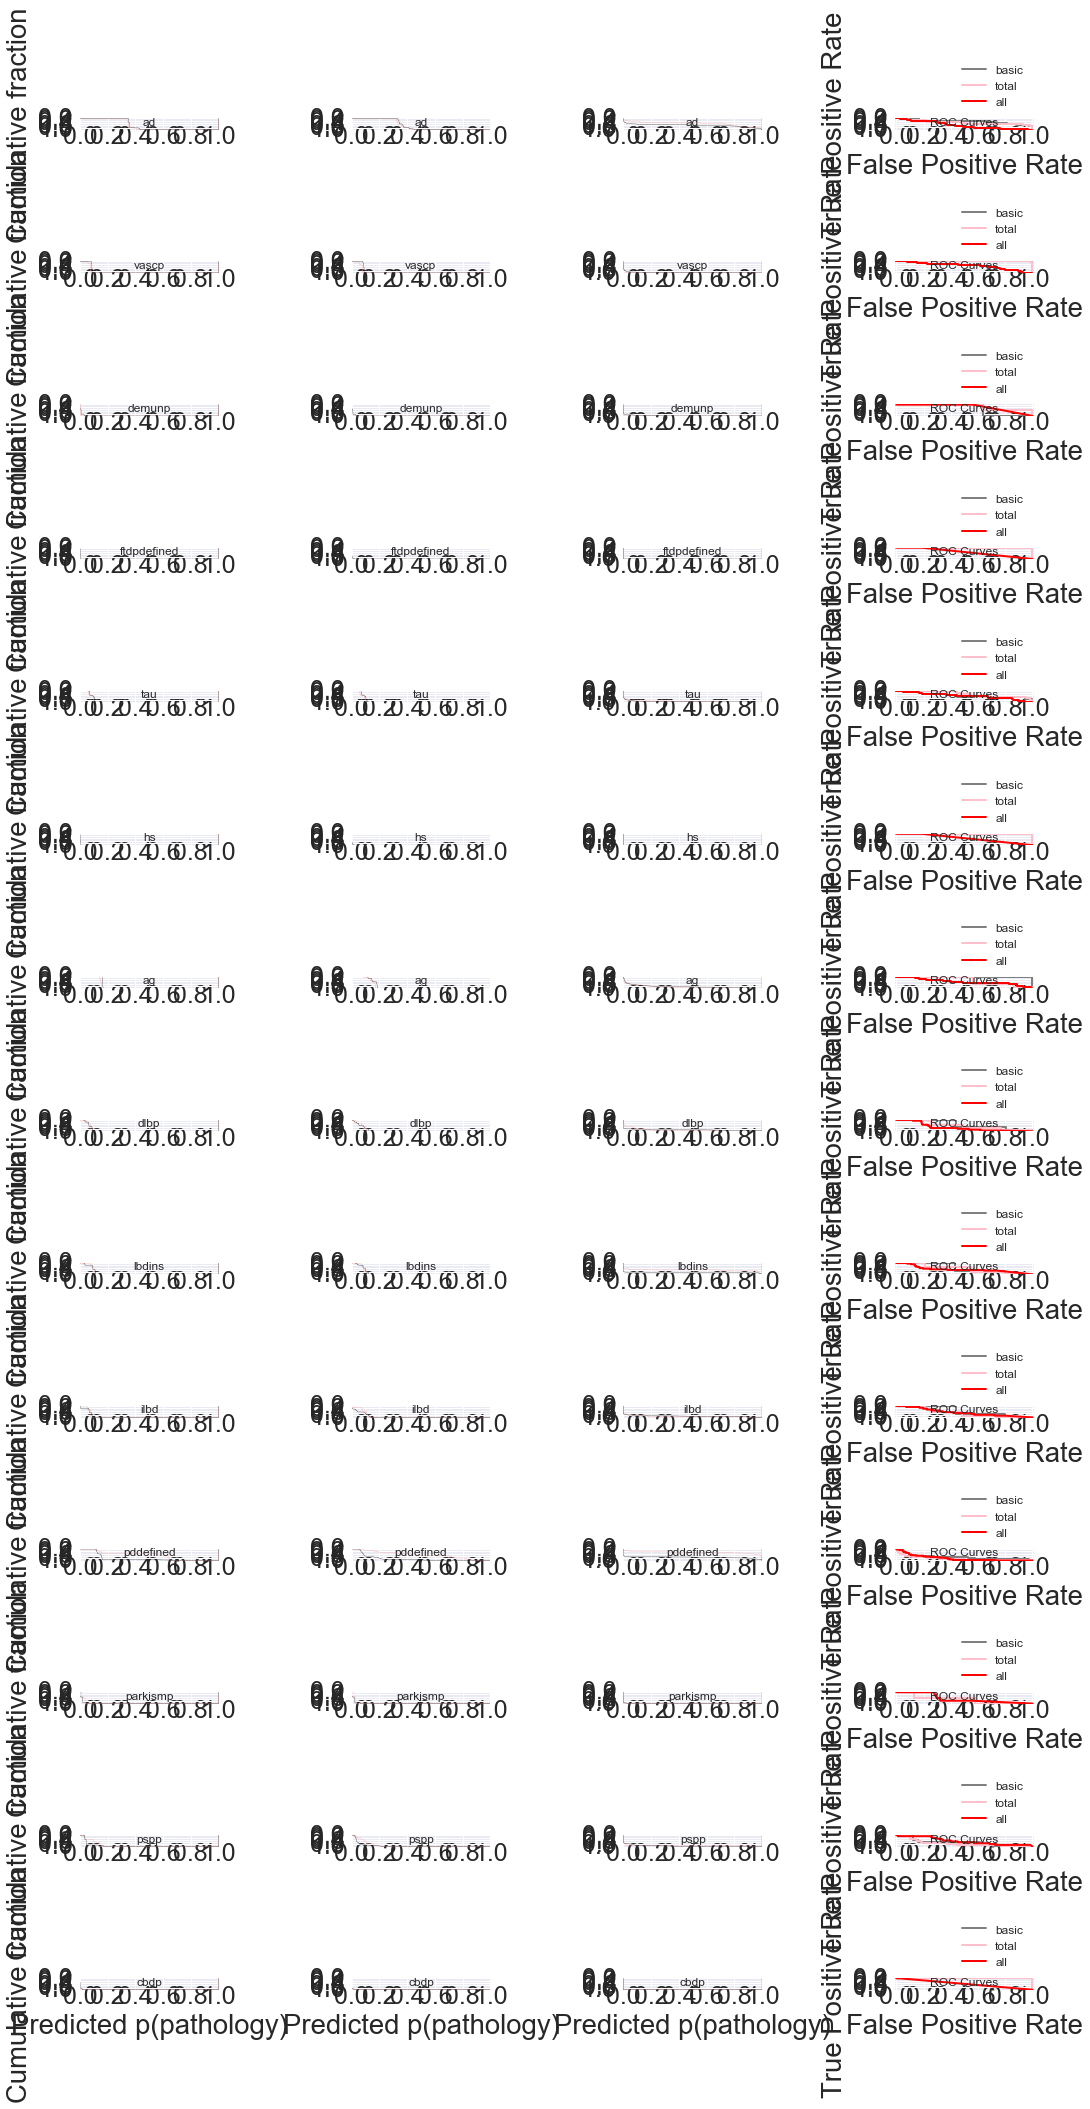

In [17]:
s.plot_roc_curves_with_ps(Y,Y_cv,Xs,p0,p1,p,pathological)
#s.plot_roc_curves_with_ps(Y,Y_cv,Xs,p0,p1,p,pathological,diagnoses=['ad','pddefined','dlbp','parkismp'])

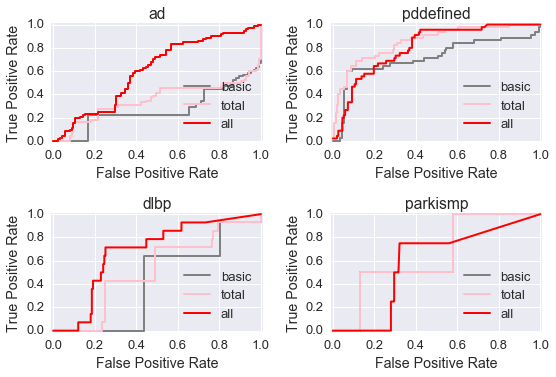

In [18]:
sns.set(font_scale=1.3)
diagnoses = ['ad','pddefined','dlbp','parkismp']
fig,ax = plt.subplots(2,2)
for i,diagnosis in enumerate(diagnoses):
    ix = list(pathological.columns.values).index(diagnosis)
    s.plot_roc_curves({key:Y_cv[key][ix] for key in Y_cv},
                      {key:p[key][ix] for key in p},
                      ax=ax.flat[i],label='sparse',title=diagnosis)
fig.tight_layout()